# Data Preparation

In [12]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [13]:
image_dataset_path = r'C:\Users\gowsh\OneDrive\Desktop\Building AI Model\dataset\images'
caption_dataset_path = r'C:\Users\gowsh\OneDrive\Desktop\Building AI Model\dataset\captions.txt'

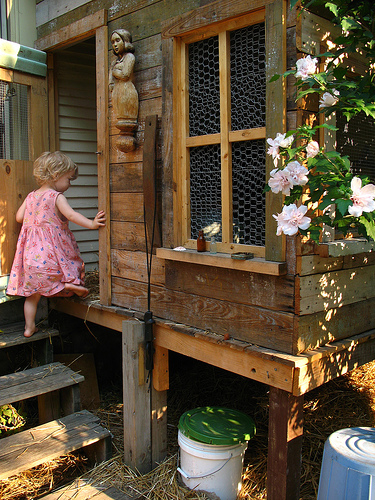

In [14]:
from IPython.display import Image
Image(r'C:\Users\gowsh\OneDrive\Desktop\Building AI Model\dataset\images\1000268201_693b08cb0e.jpg')

# Caption Processor

In [15]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

# Preprocess The Captions

In [16]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [17]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"image," : startseq  endseq


In [18]:
len(new_captions_dict)

8092

# Make a list of only those images which has caption

In [19]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [20]:
caption_images_list[0]

'1000268201_693b08cb0e'

In [21]:
len(caption_images_list)

8090

# Make training, validation and test data

In [22]:
train_validate_images = caption_images_list[0:8081]  

In [23]:
test_images = caption_images_list[8081:8091]
test_images

['985067019_705fe4a4cc',
 '987907964_5a06a63609',
 '989754491_7e53fb4586',
 '989851184_9ef368e520',
 '990890291_afc72be141',
 '99171998_7cc800ceef',
 '99679241_adc853a5c0',
 '997338199_7343367d7f',
 '997722733_0cb5439472']

# Image Feature Extractor

In [24]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

In [25]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

1000268201_693b08cb0e : [[2.507474 0.       0.       ... 0.       0.       0.      ]]


In [27]:
len(train_validate_features)

8081

In [28]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

# Preparing the input data

In [29]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [30]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [31]:
list(train_validate_image_caption.values())[0]

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

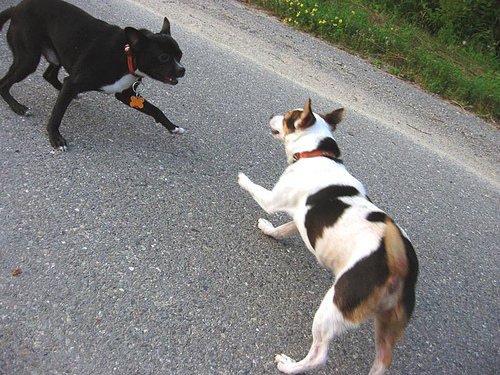

In [32]:
Image(image_dataset_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [33]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [34]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [35]:
len(train_x1)

71355

In [36]:
len(validate_x1)

10164

# Final Model

In [37]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 4096)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 30, 256)           │       1,143,296 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 4096)              │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 30, 256)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 30)                │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │       1,048,832 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ dropout_1[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense[0][0], lstm[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 4466)              │       1,147,762 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,930,994 (15.00 MB)

 Trainable params: 3,930,994 (15.00 MB)

 Non-trainable params: 0 (0.00 B)

None


# Plot the model architecture

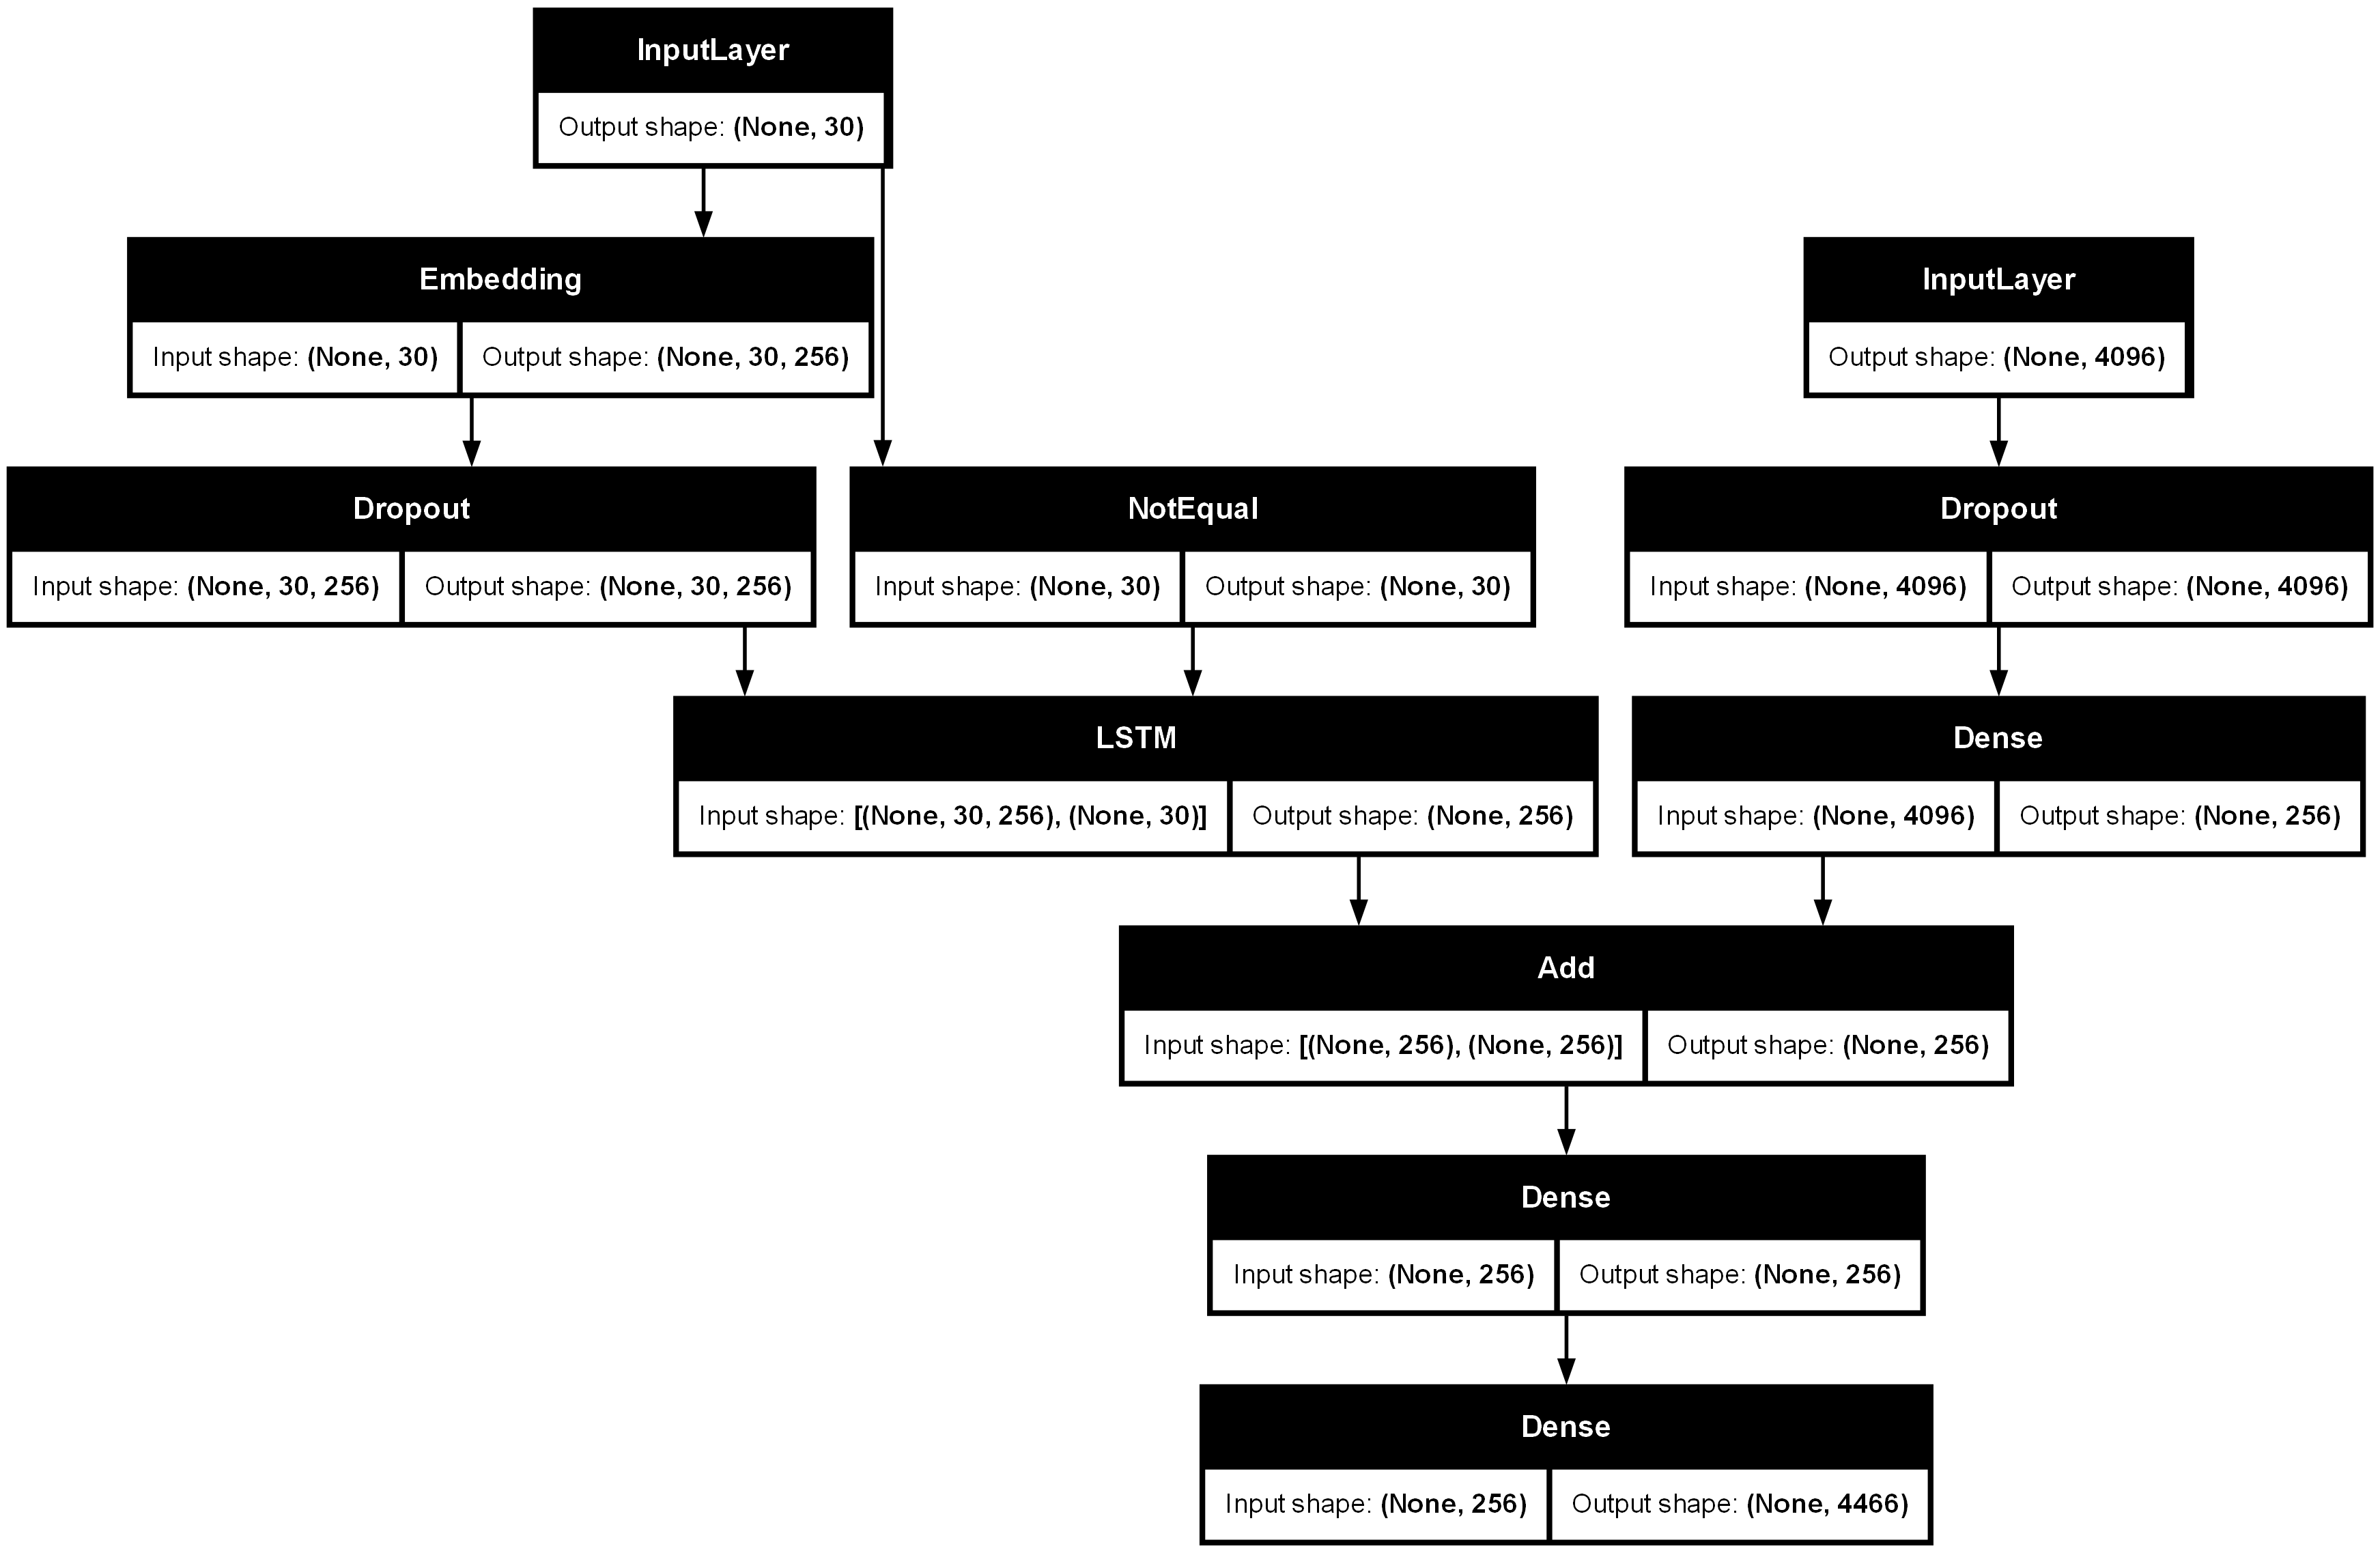

In [38]:
plot_model(model, to_file='model.png', show_shapes=True)

In [39]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Example data preparation
x_train = np.random.rand(100, 10)  # Replace with your actual training data
y_train = np.random.rand(100, 1)   # Replace with your actual training labels
x_val = np.random.rand(20, 10)     # Replace with your actual validation data
y_val = np.random.rand(20, 1)      # Replace with your actual validation labels

# Define a simple model for demonstration purposes
inputs = Input(shape=(10,))
x = Dense(64, activation='relu')(inputs)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

# Define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.keras'

callbacks = [
    ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_loss')
]

# Fit the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=callbacks)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - loss: 0.3094 - val_loss: 0.2374
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2827 - val_loss: 0.1717
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1618 - val_loss: 0.1368
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1676 - val_loss: 0.1199
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1616 - val_loss: 0.1158
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2011 - val_loss: 0.1157
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1813 - val_loss: 0.1163
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1180 - val_loss: 0.1171
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1459 - val_loss: 0.1195
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1687 - val_loss: 0.1222


In [40]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (71355, 4096)
shape of train_x2  (71355, 30)
shape of train_y  (71355, 4466)

shape of validate_x1  (10164, 4096)
shape of validate_x2  (10164, 30)
shape of validate_y  (10164, 4466)


# Training Model 

In [41]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Example data preparation
train_x1 = np.random.rand(100, 4096)  # Replace with your actual training data
train_x2 = np.random.randint(0, 100, (100, 30))  # Replace with your actual training data
train_y = np.random.rand(100, 1)   # Replace with your actual training labels
validate_x1 = np.random.rand(20, 4096)  # Replace with your actual validation data
validate_x2 = np.random.randint(0, 100, (20, 30))  # Replace with your actual validation data
validate_y = np.random.rand(20, 1)  # Replace with your actual validation labels

# Define a model with two inputs
input1 = Input(shape=(4096,))
input2 = Input(shape=(30,))
x1 = Dense(64, activation='relu')(input1)
x2 = Dense(64, activation='relu')(input2)
combined = Concatenate()([x1, x2])
x = Dropout(0.5)(combined)
outputs = Dense(1)(x)
model = Model(inputs=[input1, input2], outputs=outputs)

model.compile(optimizer='adam', loss='mse')

# Define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.keras'

callbacks = [
    ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_loss')
]

# Fit the model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose=1,            
                    epochs=10,            
                    callbacks=callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y))


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 1863.8315 - val_loss: 391.9163
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1116.7994 - val_loss: 342.6118
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1067.2943 - val_loss: 344.1647
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1203.9562 - val_loss: 326.5230
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1025.8285 - val_loss: 286.8005
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 819.4148 - val_loss: 226.5411
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 719.2502 - val_loss: 240.0865
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 620.7299 - val_loss: 275.0193
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 648.0704 - val_loss: 241.9111
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 581.4498 - val_loss: 192.4129


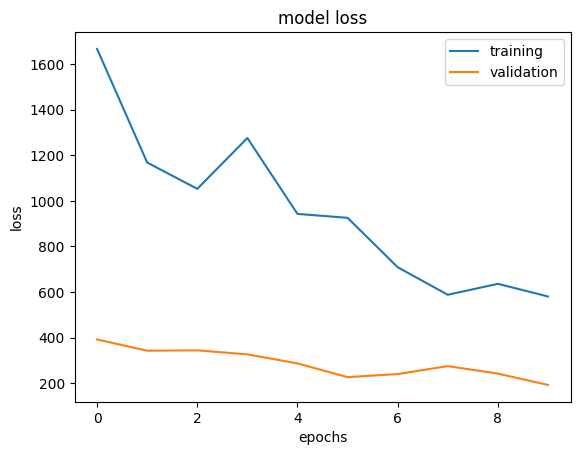

In [42]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [43]:
# saving the model with last parameter 
model.save('./latest_model.h5')

# Evaluate the model

In [44]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [45]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [47]:
# Inspect the model input shape
print(model.summary())


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 4096)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 30)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 64)                │         262,208 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 64)                │           1,984 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ dense_5[0][0],             │
│                               │                           │                 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 128)               │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 1)                 │             129 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 792,965 (3.02 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 528,644 (2.02 MB)

None


In [48]:
def extract_feat(image_path):
    # Your feature extraction code here
    # Ensure it returns a feature vector of size (4096,)
    pass


In [49]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

def extract_feat(image_path):
    model = VGG16(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features


# Evaluating model on training images using the latest model

In [50]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import MeanSquaredError

# Load and compile the model
custom_objects = {
    'mse': MeanSquaredError()
}
modl = load_model('./latest_model.h5', custom_objects=custom_objects)
modl.compile(optimizer='adam', loss='mse')  # Replace with the appropriate optimizer and loss

# Assuming `new_captions_dict` and `train_validate_images` are already defined
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30  # Ensure max_length matches the model's expected input shape

def generate_desc(model, tokenizer, photo, max_length):
    # Seed the generation process
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Ensure the photo features are of shape (1, 4096)
        if photo.shape != (1, 4096):
            photo = np.reshape(photo, (1, 4096))
        
        print(f'Photo shape: {photo.shape}')
        print(f'Sequence shape: {sequence.shape}')
        
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat, axis=-1)
        word = tokenizer.index_word.get(yhat[0], None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Proceed with generating descriptions
for count in range(10):
    photo = extract_feat('{}.jpg'.format(image_dataset_path + '/' + train_validate_images[count]))  
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq child in pink dress is climbing up set of stairs in an entry way endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq black dog and spotted dog are fighting endseq
*********************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
*********************************************************************



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq man lays on bench while his dog sits by him endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq man in an orange hat starring at something endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq child playing on rope net endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Photo shape: (1, 4096)
Sequence shape: (1, 30)
Predicted caption ->  startseq
Actual caption ->  startseq black and white dog is running in grassy garden surrounded by white fence

# Evaluating model on test images using the latest model

In [59]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

# Define the custom metric if not a built-in one
@tf.keras.utils.register_keras_serializable()
def mse(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

# Define the custom objects
custom_objects = {'mse': mse}

# Load the model with custom objects
modl = load_model(r'C:\Users\gowsh\OneDrive\Desktop\AI Project\latest_model.h5', custom_objects=custom_objects)

# Generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30  # Update this to match the model's expected sequence length

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

for count in range(min(10, len(test_images))):  # Ensure loop does not go out of range
    photo = extract_feat('{}.jpg'.format(image_dataset_path + '/' + test_images[count]))  

    # Generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted caption ->  startseq

Actual caption ->  startseq boy goes down an inflatable slide endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
Predicted caption ->  startseq

Actual caption ->  startseq brown and white dog chasing black and white dog through the grass endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted caption ->  startseq

Actual caption ->  startseq girl in pool wearing goggles and surrounded by other children endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Predicted caption ->  startseq

Actual caption ->  startseq black dog has dumbbell in his mouth endseq
*********************************************************************

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Predicted caption ->  startseq

Actual caption ->  startseq m